# Predicting NHL Clutch Goalscorers

This project applies machine learning techniques to identify and predict NHL forwards who excel in “clutch” situations (close, tied, and overtime games). The goal is not only to measure clutch performance but also to model expected clutch scoring given a player’s underlying metrics and understand the reasoning behind the predictions.

The final model has been deployed to a [Streamlit Dashboard](https://shak789-nhl-clutch-goalscorers-app-dpjtq2.streamlit.app/) that is updated at 9:00 a.m. EST daily.

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import FitFailedWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)

import time
import math
import json
import requests
import functools as ft
import scipy.stats as stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, PrecisionRecallDisplay, make_scorer
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA
from sklearn.utils import resample

import shap

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

import joblib

### NHL API

In [5]:
all_seasons = []

for season in range(2021, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'timeOnIcePerGame': 'mean'
        }).reset_index(drop = True)
print(nhl_api_df)

Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
Successfully fetched data for season 2023-2024
      playerId     skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0      8465009        Zdeno Chara            D           72       12        0   
1      8466138       Joe Thornton            C           34        5        0   
2      8469455       Jason Spezza            C           71       13        0   
3      8470281       Duncan Keith            D           64       20        0   
4      8470595         Eric Staal            C           72       15        0   
...        ...                ...          ...          ...      ...      ...   
1250   8484314       Jiri Smejkal            L           20        1        0   
1251   8484321  Nikolas Matinpalo            D            4        0        0   
1252   8484325    Waltteri Merela            C           19        0        0   
1253   8484326        Patrik Koch            D   

### Cleaning the NHL API Data
-  Only forwards are included since defensemen score at different rates. 
-  Players must have appeared in at least 60 games across the three seasons (approximately 20 games each season). This ensured that there was a sufficient sample size for each player.

In [7]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)

rename_columns = {
    'otGoals': 'ot_goals',
    'skaterFullName': 'Player',
    'timeOnIcePerGame': 'time_on_ice_per_game'
}

nhl_api_df.rename(columns = rename_columns,  inplace = True)

### Scraping Data from Natural Stat Trick

In [9]:
start_season = "20212022"
end_season = "20232024"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
on_ice_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=5v5&score=all&stdoi=oi&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [10]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
    "on_ice": (on_ice_url, '')
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]
on_ice_df = dataframes["on_ice"]
on_ice_df.columns = on_ice_df.columns.str.replace('\xa0', ' ')

### Cleaning Data from Natural Stat Trick
Similar to the NHL API data, only players who have played at least 60 games are included. The dataframes have already been filtered for forwards through the URLs.


In [12]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rebounds Created', 'iCF']]
on_ice_df = on_ice_df[['Player', 'Off. Zone Starts', 'On The Fly Starts']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df, on_ice_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]

rename_columns = {
    'Shots': 'shots',
    'Rebounds Created': 'rebounds_created',
    'Off. Zone Starts': 'off_zone_starts',
    'On The Fly Starts': 'on_the_fly_starts'
}

merged_natural_stat.rename(columns = rename_columns, inplace=True)

### Standardize Player Names
Some players from Natural Stat Trick have different names compared to the NHL API. It is important to use standard names in both dataframes before merging them.


In [14]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Thomas Novak", "Zack Bolduc", "Frederic Gaudreau"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Tommy Novak", "Zachary Bolduc", "Freddy Gaudreau"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

### Merging the Data
The dataframes containing the information from the NHL API and Natural Stat Trick are merged.

In [16]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')
merged_clutch_goals = merged_clutch_goals.dropna()

### Changing Columns
Compute per game stats to accurately compare players.

In [18]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)
columns = ['ot_goals', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'rebounds_created', 'off_zone_starts', 'on_the_fly_starts']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


### Clutch Score
After cleaning the data, we can now compute a weighted clutch score for each player.
- Goals scored when tied and down by one are given the most weighting since these are the most representative of high-pressure situations.
- Goals scored when up by one are still close situations but may not be as "clutch" compared to goals scored when tied and down by one.
- OT goals are also given a smaller weight, since they occur infrequently compared to other goals. They are also only scored during 3v3 play, which differs from regular 5v5.

In [20]:
merged_clutch_goals['clutch_score'] = (
    0.45 * merged_clutch_goals['goals_down_by_one_per_game'] + 
    0.35 * merged_clutch_goals['goals_when_tied_per_game'] + 
    0.2 * merged_clutch_goals['ot_goals_per_game']
)

### Rankings Players Based on their Clutch Score
All scores are multiplied by 100 to make them more interpretable.
The scores are then ranked and the top 20 players are shown below.

In [22]:
merged_clutch_goals['clutch_score'] *= 100
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
318,Auston Matthews,14.96,1.0
236,David Pastrnak,13.50,2.0
304,Kirill Kaprizov,13.25,3.0
222,Leon Draisaitl,12.26,4.0
267,Connor McDavid,12.16,5.0
152,Filip Forsberg,11.44,6.0
453,Jack Hughes,11.01,7.0
245,Brayden Point,10.81,8.0
346,Tage Thompson,10.64,9.0
50,Steven Stamkos,10.52,10.0


### Distribution of Clutch Scores
As shown by the histogram below, the data for clutch scores is right skewed. Most players have a below average clutch score and there are a small number of elite players


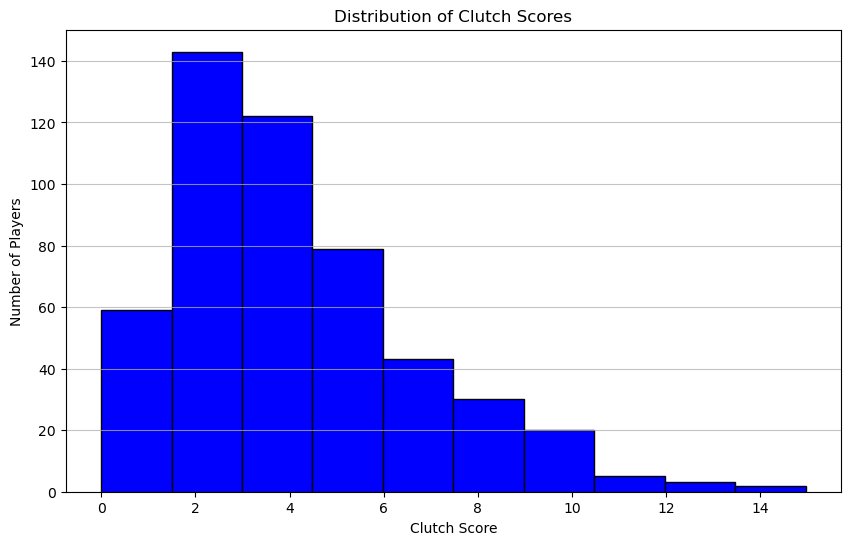

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Clutch Score")
plt.ylabel("Number of Players")
plt.title("Distribution of Clutch Scores")
plt.show()

### Threshold for Clutch Scores
It makes sense to label "clutch" goalscorers as a higher percentile of data. Thus, all players who had a clutch score in the 85th percentile were in the positive class.
This approach already highlights the potential shortcomings of classification for this project. Is a player in the 80 to 84th percentile suddenly not "clutch"? Even if we used a multiclass classification approach, how can we distinguish between players who fall near the boundaries?

In [26]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)

def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

### Class Imbalance
Due to the right skew distribution of the data, there are very few goalscorers classified as "clutch".

In [28]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    430
1     76
Name: count, dtype: int64

### Setting up a Classification Model

My initial approach was to select various classification models (e.g. XGBoost, random forest, KNN) and compare them with the Friedman statistical test. I started working on an XGBoost model, but then realized that a classification approach was noidealea.


### Starting with XGBoost

A full glossary of the features can be found on the __[Natural Stat Trick website.](https://www.naturalstattrick.com/glossary.php?players)__


In [31]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game', 
         'off_zone_starts_per_game', 'on_the_fly_starts_per_game']
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Inflated Accuracy

The model's accuracy appears to be quite high (approximately 90%), but this is most likely due to the high class imbalance. The model can predict the majority class most of the time, without effectively learning to identify the minority class.

The model seems to have a high precision and low recall. It is very cautious about predicting the minority class (clutch goalscorers), which results in fewer false positives. So when the model predicits positive, it is mostly correct. However, this means that the model misses many clutch goalscorers and has a low recall. 

The F1 score is pulled down by the low recall to highlight the model's issues with rarely predicting the positive class and missing clutch goalscorers.

In [33]:
skf = StratifiedKFold(n_splits=10)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

fit_time          0.043405
score_time        0.011734
test_accuracy     0.895451
test_precision    0.843116
test_recall       0.621429
test_f1           0.651007
dtype: float64

### Learning Curves
The learning curves plot the log loss of the training against the log loss for cross-validation. The very low log loss for training indicates that the model has nearly 100% accuracy in predicting clutch players from the training data. However, the log loss increases to 0.4 on the cross-validation data. Due to the high negative class imbalance, the model can just predict non-clutch most of the time. When it predicts the positive class, it may not be confident enough which shows the model has memorized the patterns in the training data and cannot generalize to new data during cros- validation
Note: The high imbalance in the dataset means that stratified cross-validation may not be able to create balanced splits, leading to the error message.


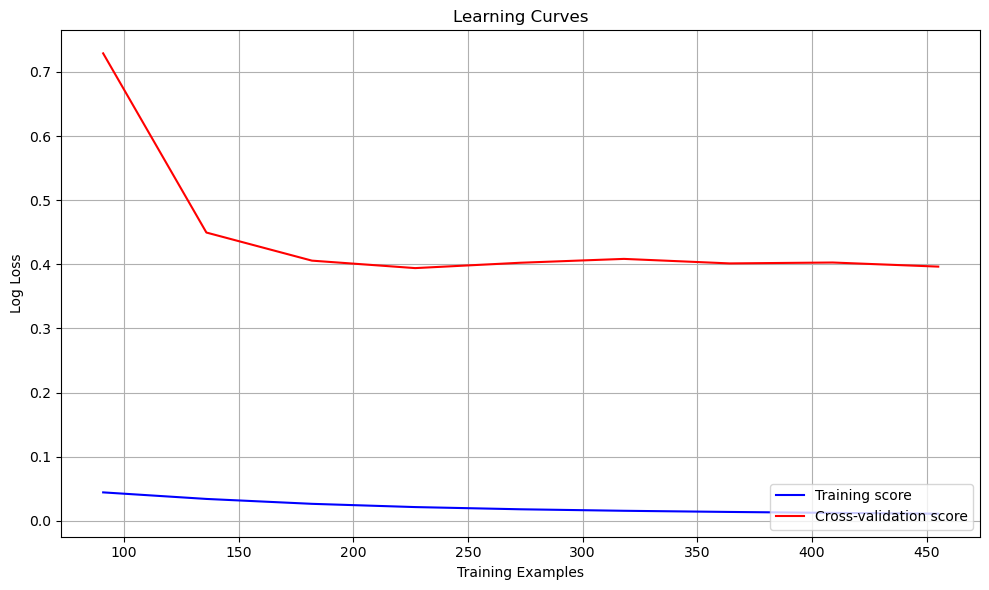

In [35]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss'
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Hyperparameter tuning
Hyperparameter tuning involves adjusting parameters to improve the model's metrics and reduce overfitting. These parameters are set before training since the model cannot learn them from the data. Below are hyperparameters that are tuned for the XGBoost model better generalization.


In [37]:
from scipy.stats import randint, uniform

param_grid = {
    'max_depth': randint(2, 6),
    'min_child_weight': randint(2, 4),
    'n_estimators': randint(200, 301), 
    'learning_rate': uniform(0.03, 0.01),
    'reg_alpha': uniform(0.75, 0.6), 
    'reg_lambda': uniform(0.75, 0.6), 
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3) 
}


### Random Search

I have repeated random search multiple times on different train and test splits to obtain a good representation of the model's performance. After each train and test split, the model's class weights are adjusted.


### Results of Hyperparameter Tuning

From the learning curves, it seems that hyperparameter tuning has helped to reduce overfitting.

With regards to the model's performance metrics, it is simply not enough to look at the recall and precision score. We must understand where the model is misclassifying clutch players.

After each randomly selected train test split, I printed out the model's classification results. It appears that the model can correctly classify higher ranked players but struggles with players close to the boundary points (ranks between 45 and 74). The model also incorrectly classifies players with varying performance over the three seasons. 

This makes sense because we are essentially assigning an ambiguous label to a clutch player. Is a player 0n the 84th to 83rd percentile suddenly not clutch? Classification may also have difficulties detecting trends in player performance.


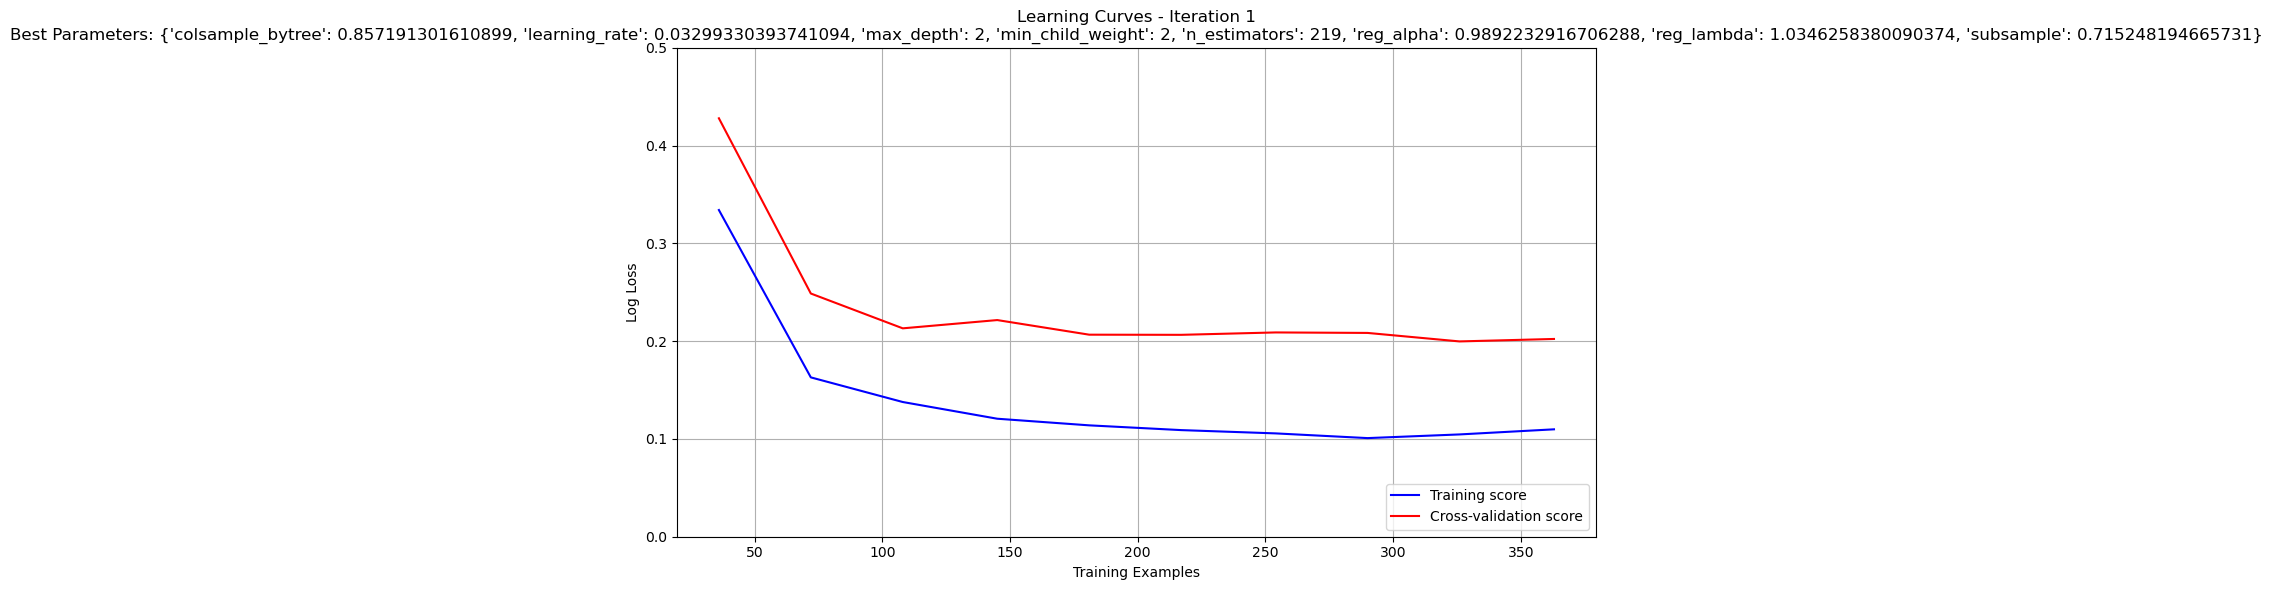


Precision Score:  0.7333333333333333
Recall Score:  0.7333333333333333

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
185  Carter Verhaeghe               67.0       1          1
16      Sidney Crosby               28.0       1          1
11      Evgeni Malkin               57.0       1          1
372     Nico Hischier               44.0       1          1
325    Clayton Keller               25.0       1          1
229      Dylan Larkin               14.0       1          1
413     Brady Tkachuk               30.0       1          1
268       Jack Eichel               27.0       1          1
245     Brayden Point                8.0       1          1
267    Connor McDavid                5.0       1          1
324      Patrik Laine               42.0       1          1

Missed Cltuch Players
                 Player  clutch_score_rank  Actual  Predicted
390         Josh Norris               13.0       1          0
228         Jakub Vrana              

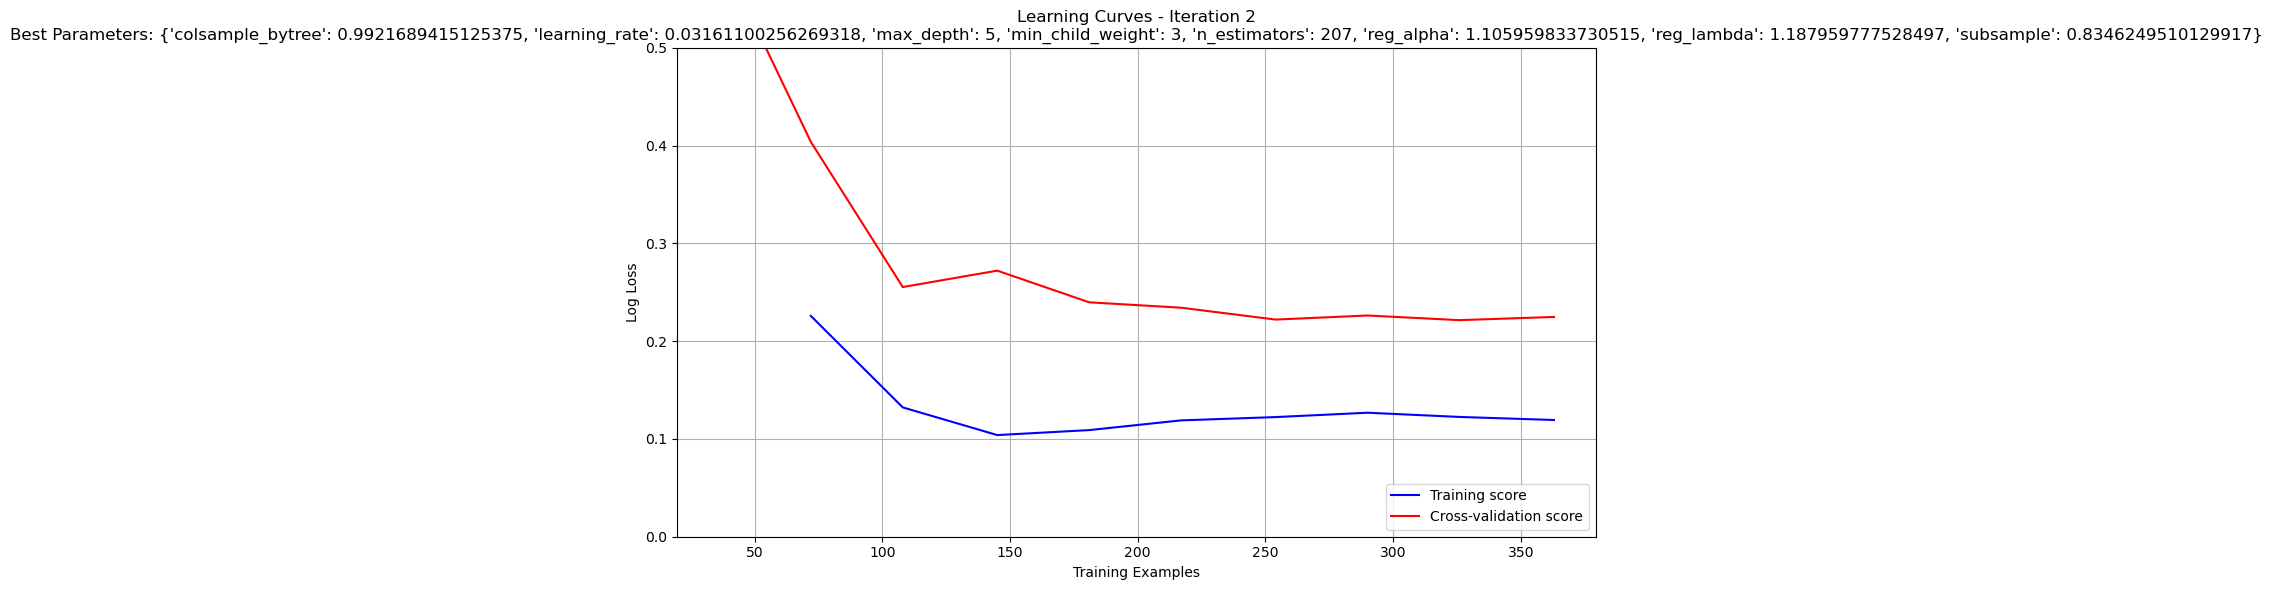


Precision Score:  0.8461538461538461
Recall Score:  0.7333333333333333

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
221      Sam Reinhart               19.0       1          1
318   Auston Matthews                1.0       1          1
267    Connor McDavid                5.0       1          1
121      Boone Jenner               39.0       1          1
201  Nathan MacKinnon               18.0       1          1
130    Mika Zibanejad               29.0       1          1
182     Jake Guentzel               50.0       1          1
23      Brad Marchand               58.0       1          1
290      Mitch Marner               37.0       1          1
133       J.T. Miller               53.0       1          1
346     Tage Thompson                9.0       1          1

Missed Cltuch Players
               Player  clutch_score_rank  Actual  Predicted
381       Nick Suzuki               65.0       1          0
428  Kirill Marchenko               56.0 

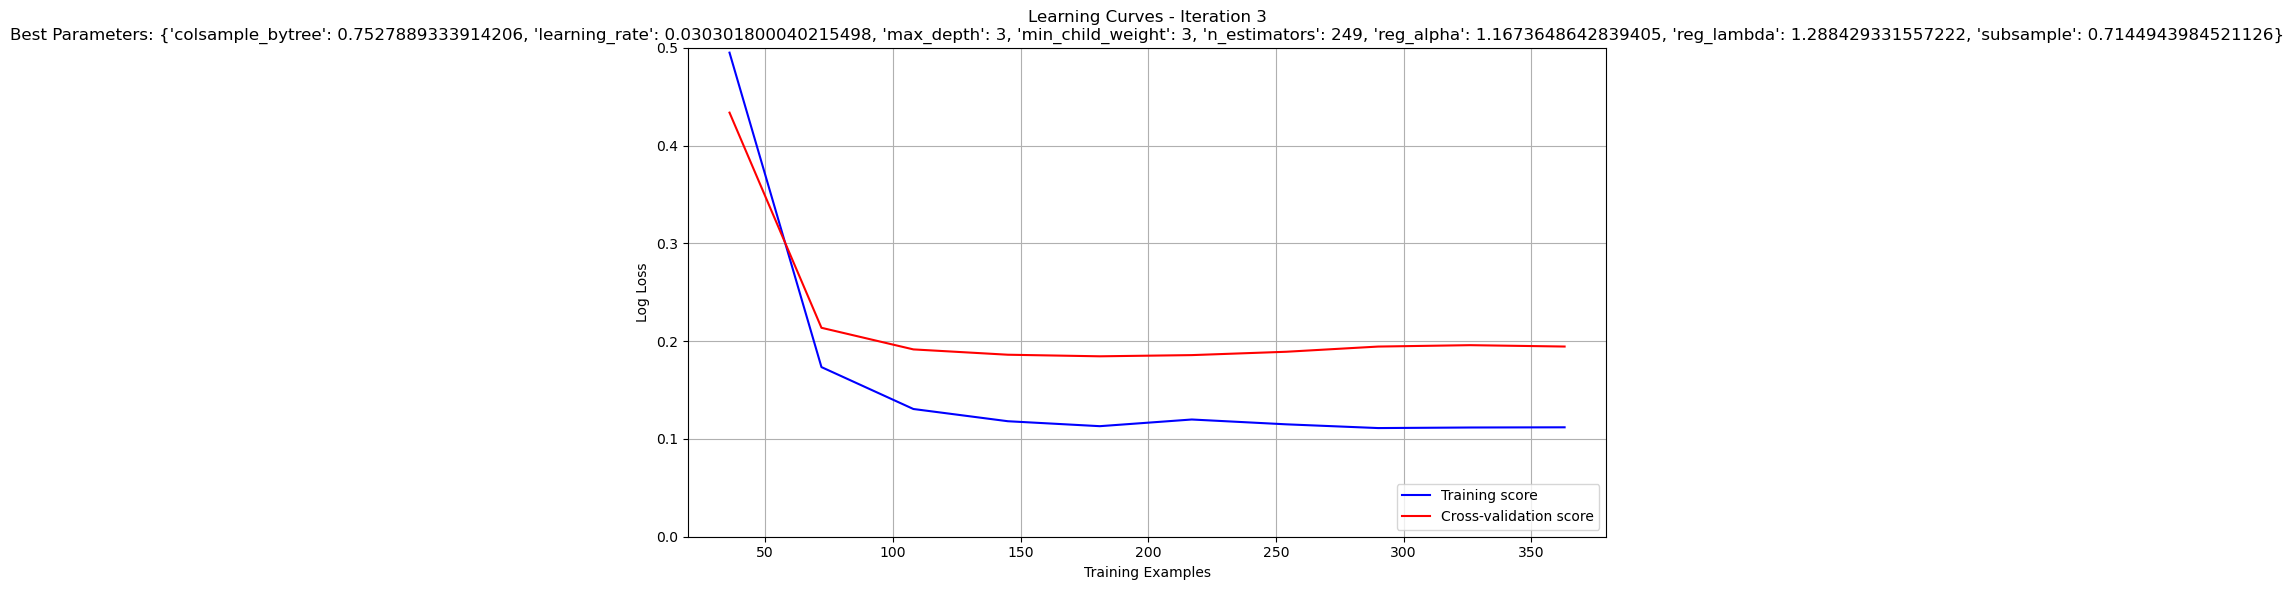


Precision Score:  0.6363636363636364
Recall Score:  0.4666666666666667

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
227       Kevin Fiala               62.0       1          1
225    Nikolaj Ehlers               68.0       1          1
268       Jack Eichel               27.0       1          1
236    David Pastrnak                2.0       1          1
185  Carter Verhaeghe               67.0       1          1
133       J.T. Miller               53.0       1          1
413     Brady Tkachuk               30.0       1          1

Missed Cltuch Players
                 Player  clutch_score_rank  Actual  Predicted
93   Vladimir Tarasenko               76.0       1          0
379     Gabriel Vilardi               46.0       1          0
235        Jared McCann               60.0       1          0
283         Roope Hintz               16.0       1          0
381         Nick Suzuki               65.0       1          0
343        Jesper Bratt      

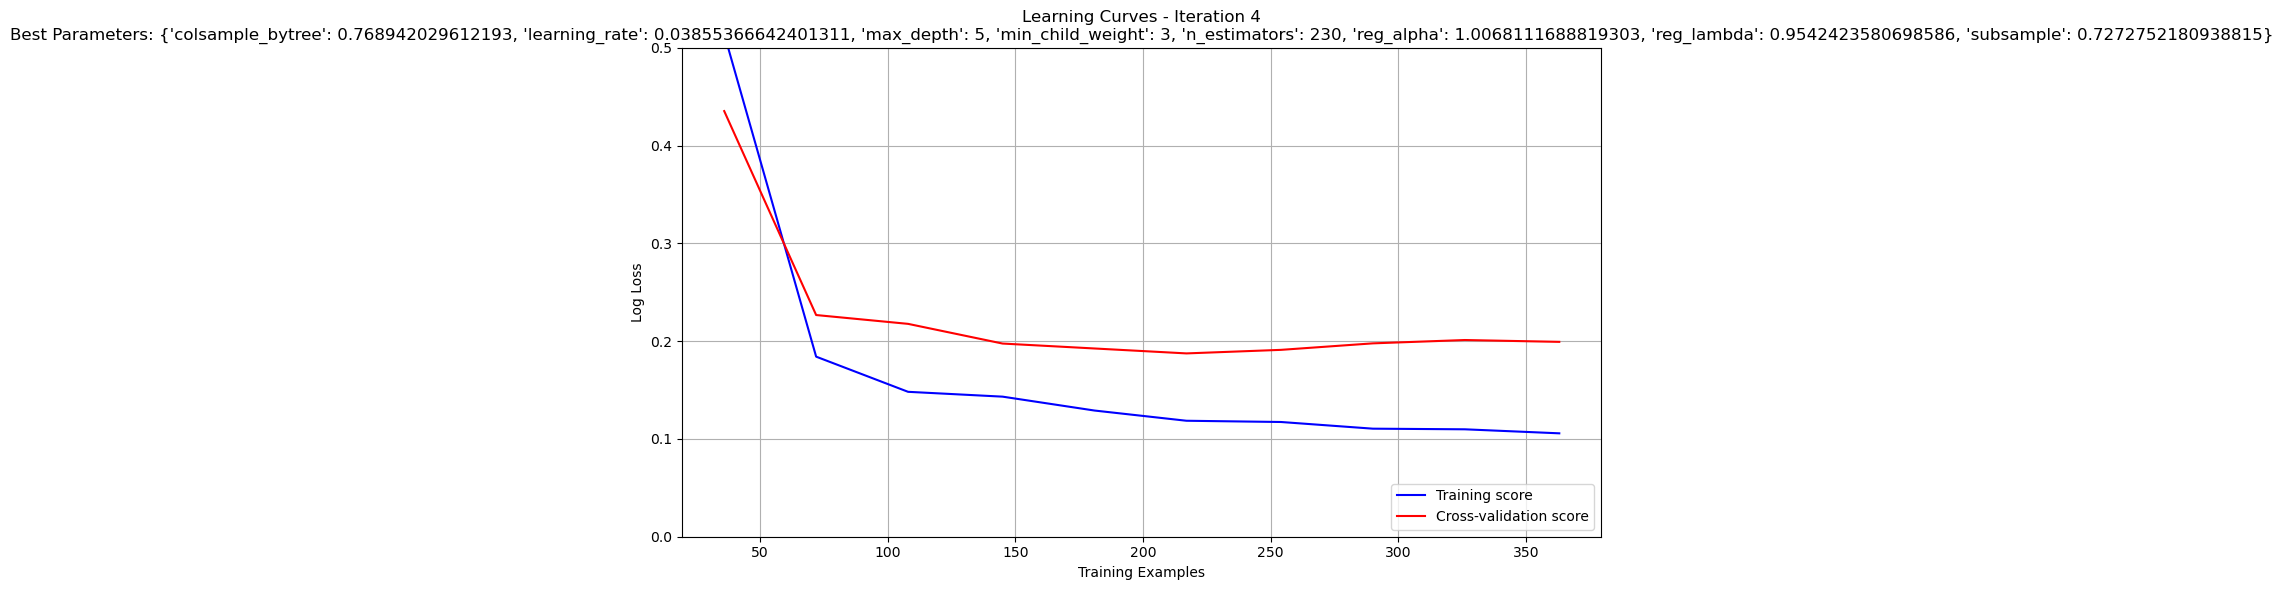


Precision Score:  0.6666666666666666
Recall Score:  0.8

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
271    Mikko Rantanen               17.0       1          1
298    Artemi Panarin               24.0       1          1
291  Joel Eriksson Ek               70.0       1          1
225    Nikolaj Ehlers               68.0       1          1
130    Mika Zibanejad               29.0       1          1
339      Jordan Kyrou               59.0       1          1
304   Kirill Kaprizov                3.0       1          1
449     Cole Caufield               31.0       1          1
236    David Pastrnak                2.0       1          1
68       Evander Kane               49.0       1          1
72      Chris Kreider               32.0       1          1
11      Evgeni Malkin               57.0       1          1

Missed Cltuch Players
              Player  clutch_score_rank  Actual  Predicted
307       Troy Terry               36.0       1          

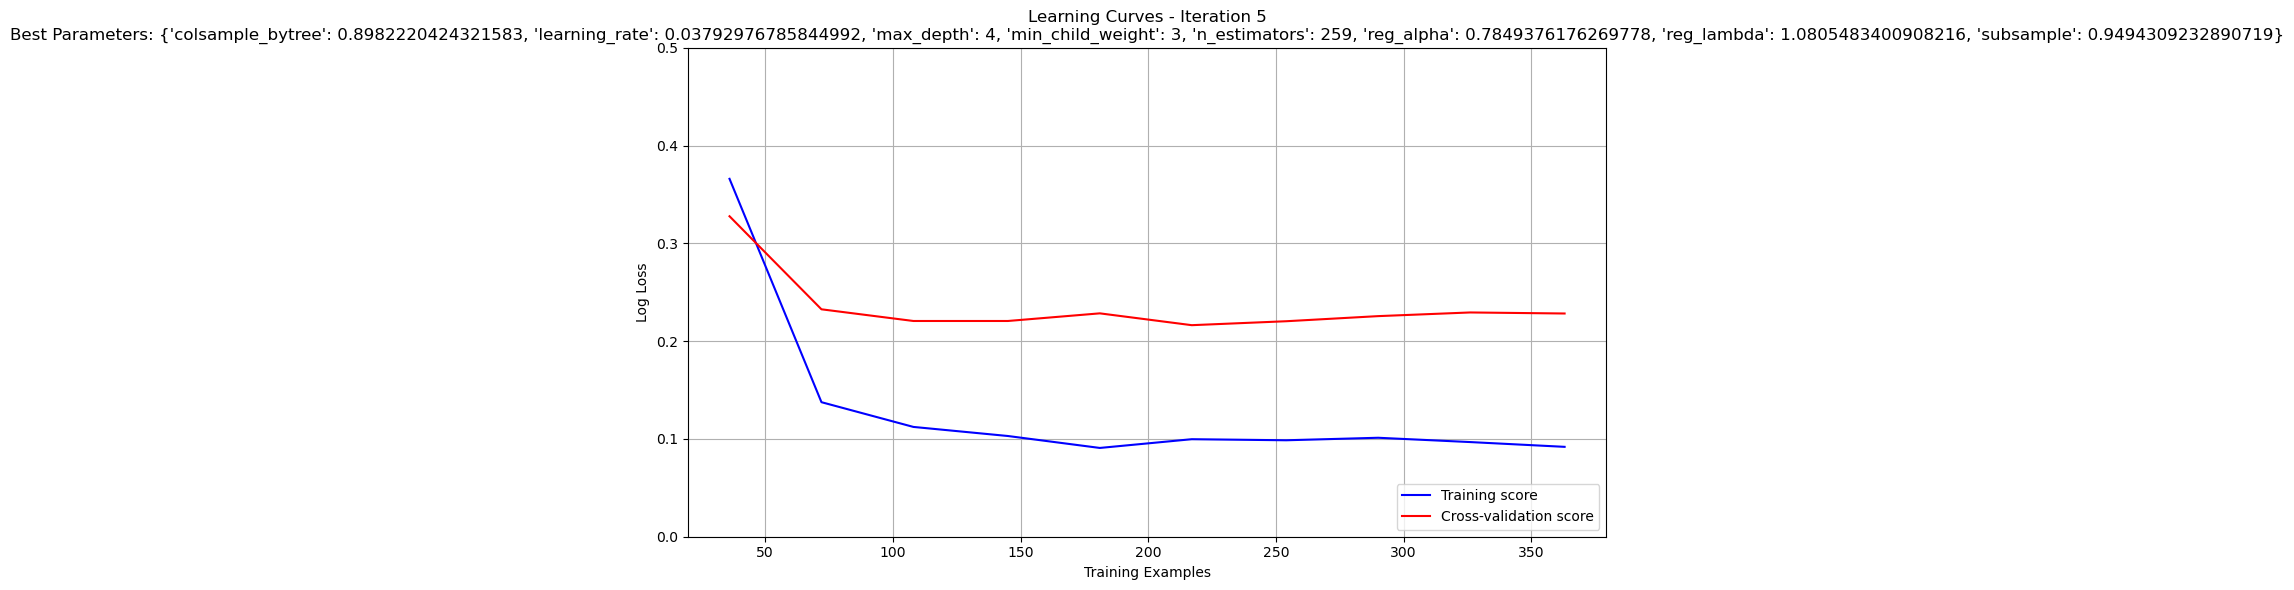


Precision Score:  0.7058823529411765
Recall Score:  0.8

Correct Classfications
               Player  clutch_score_rank  Actual  Predicted
290      Mitch Marner               37.0       1          1
274     Sebastian Aho               22.0       1          1
43       Patrick Kane               47.0       1          1
68       Evander Kane               49.0       1          1
229      Dylan Larkin               14.0       1          1
413     Brady Tkachuk               30.0       1          1
325    Clayton Keller               25.0       1          1
227       Kevin Fiala               62.0       1          1
511     Connor Bedard               33.0       1          1
150       Tomas Hertl               73.0       1          1
222    Leon Draisaitl                4.0       1          1
291  Joel Eriksson Ek               70.0       1          1

Missed Cltuch Players
               Player  clutch_score_rank  Actual  Predicted
185  Carter Verhaeghe               67.0       1        

In [40]:
from sklearn.model_selection import RandomizedSearchCV

cv = StratifiedKFold(n_splits=10)

precision_list = []
recall_list = []
f1_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Log Loss')
    plt.ylim(0, 0.5)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(5):
    rs = np.random.randint(1, 1000)

    train_x, test_x, train_y, test_y = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state = rs
    )

    class_weights = compute_sample_weight(class_weight='balanced', y=train_y)
    
    xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss')
    xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

    random_search = RandomizedSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, n_jobs = -1, scoring = 'f1')

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  

    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    print("")
    print("Precision Score: ", precision)
    print("Recall Score: ", recall)
    print("")

    
    results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[test_y.index, 'Player'],
    'clutch_score_rank': merged_clutch_goals.loc[test_y.index, 'clutch_score_rank'],
    'Actual': test_y,
    'Predicted': y_pred,
    })

    print("Correct Classfications")
    print(results.loc[(results['Actual'] == 1) & (results['Predicted'] == 1)])

    print("")

    print("Missed Cltuch Players")
    print(results.loc[(results['Actual'] == 1) & (results['Predicted'] == 0)])

    print("")

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

### Switching to Regression

Although the classification model does show advantages in correctly classifying some player, I believe that regression is more suitable:

1. Unlike Classification, regression can be used to predict the player's clutch score (a continuous label), rather than assigning them to classes that may not clearly define a "clutch player". This makes the model easier to interpret and leads to more accurate predictions.
2. Regression can account for the trends in player performance and provide better predictions.


### Features
The same features from classification are used. These features show a strong positive correlation with clutch score, which indicates that a linear regression model is suitable


In [43]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 
         'assists_per_game', 'iCF_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game', 
         'off_zone_starts_per_game']
X= merged_clutch_goals[x_var]
y_var = 'clutch_score'  
y = merged_clutch_goals[y_var]

correlation = X.corrwith(y) 
print(correlation)

shots_per_game               0.864417
ixG_per_game                 0.854483
iFF_per_game                 0.869267
iSCF_per_game                0.876447
iHDCF_per_game               0.694483
assists_per_game             0.745530
iCF_per_game                 0.863786
rebounds_created_per_game    0.781373
time_on_ice_per_game         0.771436
off_zone_starts_per_game     0.744034
dtype: float64


### Scatter Plots
The scatter plots further show the strong positive correlation of the features with clutch score.

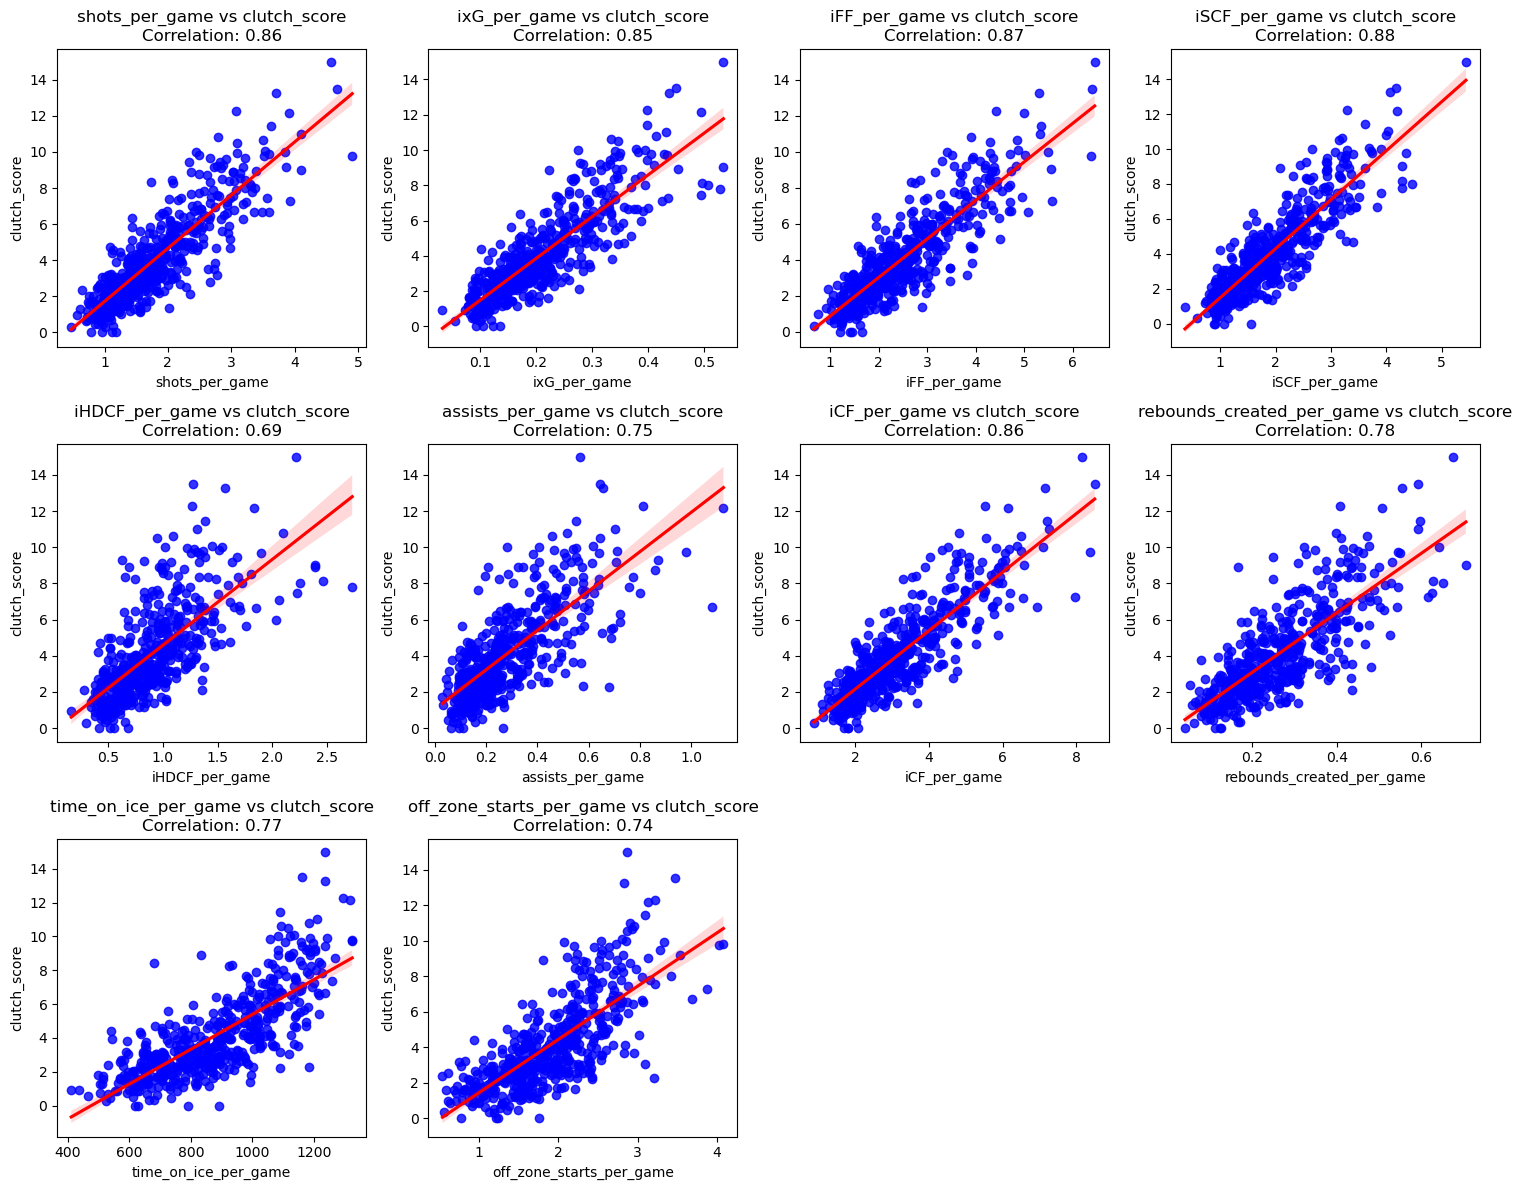

In [45]:
plt.figure(figsize=(15, 12))  

for i, var in enumerate(x_var):
    plt.subplot(3, 4, i+1)
    
    sns.regplot(data=merged_clutch_goals, x=var, y=y, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    plt.title(f'{var} vs {y_var}\nCorrelation: {correlation[var]:.2f}', fontsize=12)
    plt.xlabel(var)
    plt.ylabel(y_var)

plt.tight_layout()  
plt.show()

### Multicollinearity
As the heatmap shows, there is high multicollinearity among features, which would lead to instability in coefficients and make it difficult to interpret the impact of features on the clutch score. Therefore, a small subset of features were kept (scoring chances, assists, time on ice, rebounds created, offensive zone starts).

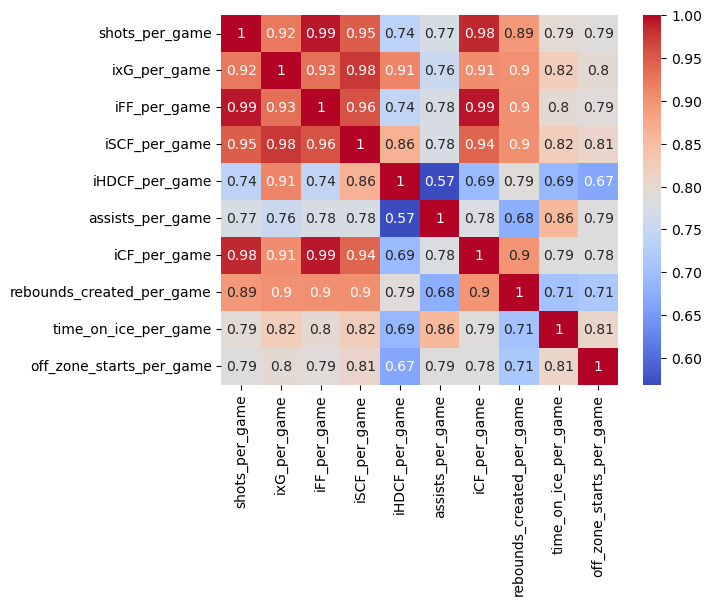

In [47]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

### Ridge Regression
Ridge regression is used to ensure there is less overfitting.
The model shows good performance because it has a low MSE of approximately 1 and R² of approximately 80%. In future sections, the outliers are evaluated to determine the model's limitations which are not obvious with the MSE and R².

In [49]:
x_var = ['iSCF_per_game', 'assists_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game', 'off_zone_starts_per_game']

X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals[y_var]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_adjusted)

train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

alphas = np.logspace(-3, 3, 20)

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(train_x, train_y)

y_pred = ridge_cv.predict(test_x)

mse = mean_squared_error(test_y, y_pred)
rmse = np.sqrt(mse)
median_error = median_absolute_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("Median Error: ", median_error)
print("R²: ", r2)
print("Adjusted R²: ", 1 - (1 - r2) * (len(train_y) - 1) / (len(train_y) - train_x.shape[1] - 1))

MSE:  1.816778370521922
RMSE:  1.3478792121410295
Median Error:  0.7598699884636728
R²:  0.7824620529478941
Adjusted R²:  0.7797291641658324


### Learning Curves

The learning curves do not show significant overfitting. After approximately 250 samples, both training and validation curves converge to an MSE of less than
2 
Thus, Ridge Regression is the correct choice for generalizing the training dat.


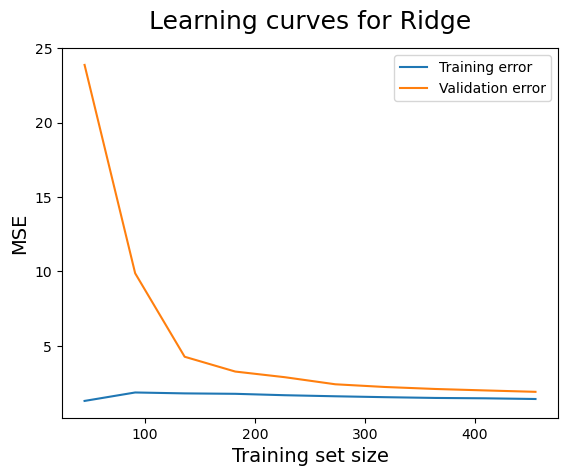

In [51]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, validation_scores = learning_curve(
ridge_cv,
X_scaled,
y, train_sizes = train_sizes, cv = 10,
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Ridge', fontsize = 18, y = 1.03)
plt.legend()

### Scatter Plot and Line of Best Fit
Since most points fall near the line of best fit, the model is generally accurate in predicting values. However, there are a few outliers which need to be corrected.

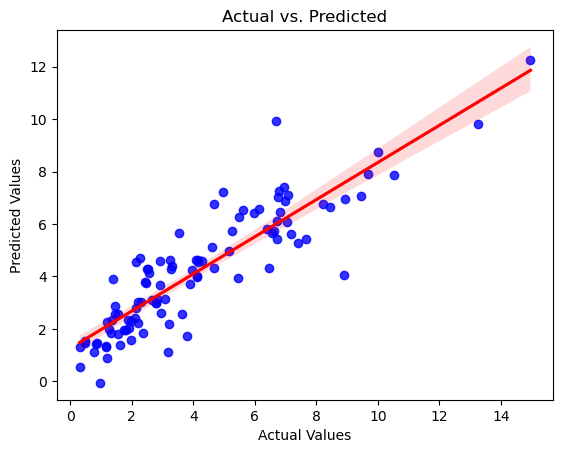

In [53]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Residual Plot
The residual plot shows more errors in predicting the clutch score are between 1 and -1. However, there are a few points outside of this range, which may be considered as outliers.

<Axes: xlabel='clutch_score'>

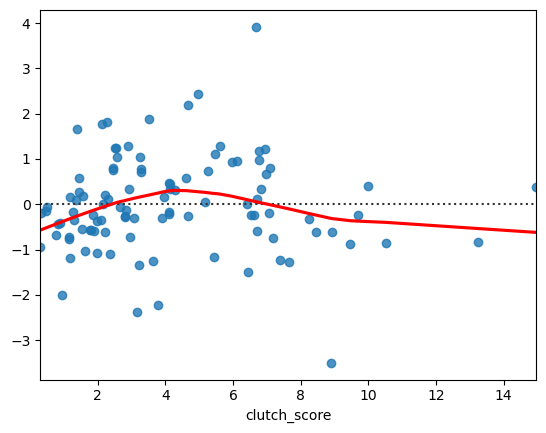

In [55]:
sns.residplot(data=merged_clutch_goals, x=test_y, y=y_pred, lowess=True, line_kws=dict(color="r"))

### Cook's Distance
Cook's distance enables us to evaluate influential points in the model. Influential points are data points that significantly change the fit of the model if removed.

As shown below, the model tends to underestimate the performance of several elite players (e.g., McDavid and Matthews) in clutch situations. These players' statistics may have created an artificial "ceiling" that limits the model’s ability to accurately predict their scoring ability in close and tied situations.

Conversely, the model overestimates the performance of other elite players (e.g., Matthew Tkachuk), who do not perform as well in clutch scoring situations as their general statistics suggest.


There are 45 influential points.
Outliers based on Cook's Distance:
                  Player  Actual  Predicted  Cook's Distance
318      Auston Matthews   14.96  13.027892         0.037989
236       David Pastrnak   13.50  10.221958         0.031744
304      Kirill Kaprizov   13.25  10.023435         0.024740
222       Leon Draisaitl   12.26   8.619711         0.036664
267       Connor McDavid   12.16  11.258861         0.009111
152       Filip Forsberg   11.44   8.672784         0.019481
346        Tage Thompson   10.64   7.553515         0.010428
50        Steven Stamkos   10.52   7.794900         0.011200
390          Josh Norris   10.00   6.041798         0.032389
229         Dylan Larkin    9.93   7.956490         0.008622
283          Roope Hintz    9.83   7.294436         0.008227
201     Nathan MacKinnon    9.75  11.465788         0.017908
206            Bo Horvat    9.61   7.510754         0.011934
131       Mark Scheifele    9.46   7.309917         0.016853
298       Artemi 

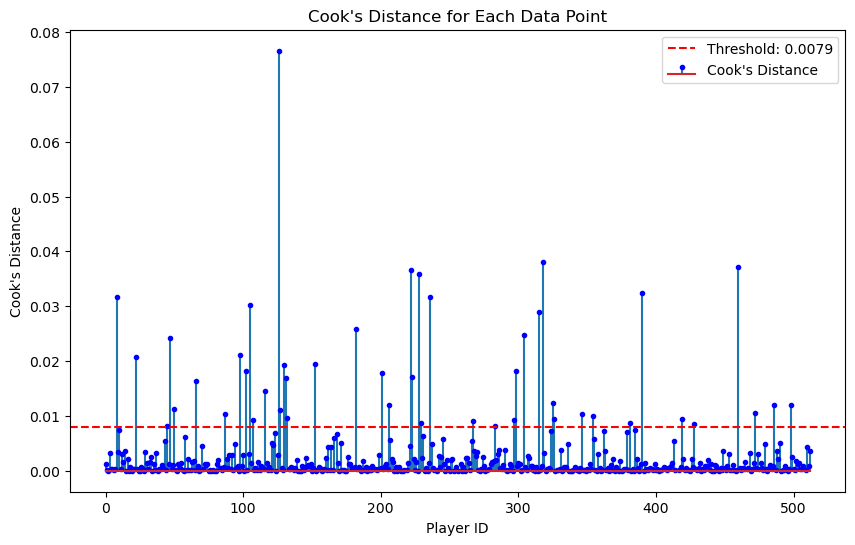

In [57]:
X_with_intercept = sm.add_constant(X_scaled)

ols_model = sm.OLS(y, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)
outliers = np.where(cooks_d > threshold)[0]

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index, 'Player'],
    'Actual': y,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.loc[results["Cook's Distance"] > threshold]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

### Evaluating the Distribution of the Data

The histogram and QQ plot show that the data has a right skew distribution, which may explain why the model has difficulties in predicting the clutch score of elite players on the right side of the tail.


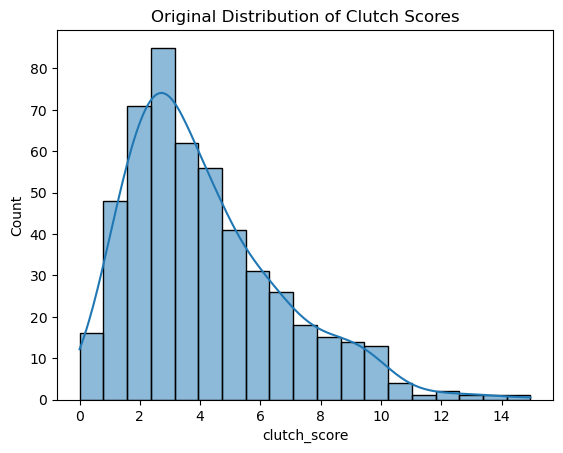

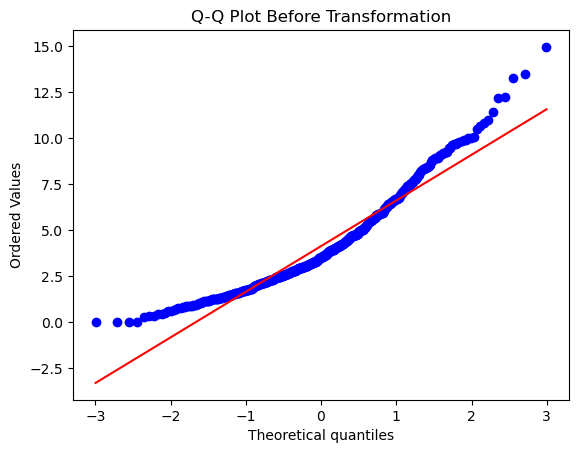

In [59]:
sns.histplot(y, kde=True)
plt.title("Original Distribution of Clutch Scores")
plt.show()
stats.probplot(y, dist="norm", plot=plt)
plt.title("Q-Q Plot Before Transformation")
plt.show()

### Transforming the Data to a Normal Distribution with Log

As shown below, a log transformation is used to reduce the skew of the data and create a normal distribution. This ensures the predictions are not affected by the influential points we identified in Cook's distance.


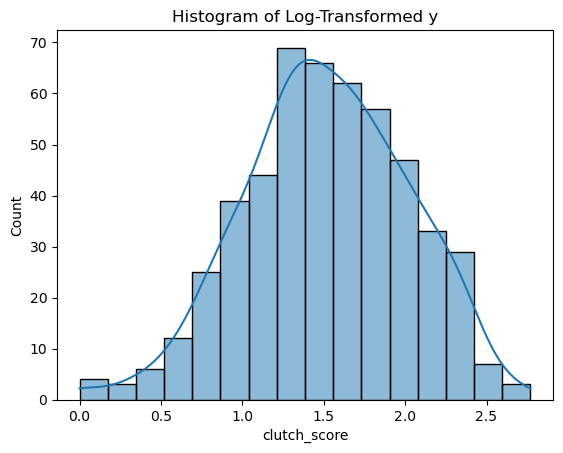

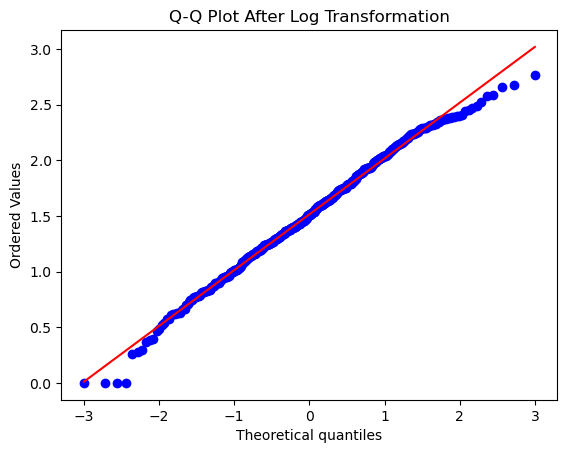

In [61]:
y_log = np.log(y + 1)  

sns.histplot(y_log, kde=True)
plt.title("Histogram of Log-Transformed y")
plt.show()

stats.probplot(y_log, dist="norm", plot=plt)
plt.title("Q-Q Plot After Log Transformation")
plt.show()

### Calculating Cook's Distance 

After we apply the log transformation and calculate Cook's distance, we can see that the elite players are no longer influential points. However, there are some players which the model still struggles with. The model undervalues some players (e.g. Vrana, Laine) who may perform better in close and tied situations than their metrics suggest. On the other hand, some players are overvalued and may have better metrics that may not fully reflect their clutch performance (e.g. Matthew Tkachuk, Nikita Kucherov). While influential points are often viewed negatively, they can provide valuable insights. These points could help NHL coaching staff and management identify players who perform well in high-pressure situations, even if they aren’t considered elite based on traditional metrics.

Finally, some below-average players become influential because the log transformation tends to amplify the difference between smaller actual and predicted values.


In [63]:
epsilon = np.abs(X_scaled.min()) + 1
X_shifted = X_scaled + epsilon
y_log = np.log(y + 1)
X_log = np.log(X_shifted)

train_x, test_x, train_y, test_y = train_test_split(
    X_log,
    y_log,
    test_size=0.2,
    random_state=200
)

alphas = np.logspace(-3, 3, 20)
ridge_cv_log = RidgeCV(alphas=alphas, cv=5)
ridge_cv_log.fit(train_x, train_y)
y_pred = ridge_cv_log.predict(test_x)

There are 26 influential points.
Outliers based on Cook's Distance:
                Player    Actual  Predicted  Cook's Distance
228        Jakub Vrana  2.291524   1.563531         0.023625
460    Pavel Dorofeyev  2.243896   1.703203         0.017004
126    Nikita Kucherov  2.037317   2.345150         0.010375
355    Michael Carcone  1.890095   1.277452         0.008042
486    Alexander Holtz  1.736951   1.177567         0.015785
498       Walker Duehr  1.688249   1.006267         0.026980
362     Vinni Lettieri  1.654411   0.947276         0.014116
490        Will Cuylle  1.597365   1.227084         0.010899
123      Brett Ritchie  1.566530   0.988282         0.021923
94       Austin Watson  1.427916   0.811915         0.014430
363         Mason Shaw  1.269761   0.808278         0.017283
164   Dominic Toninato  1.214913   0.717981         0.032529
102    Mikael Granlund  1.193922   1.676579         0.011728
47       Jakub Voracek  1.187843   1.497233         0.012313
22    Patric Horn

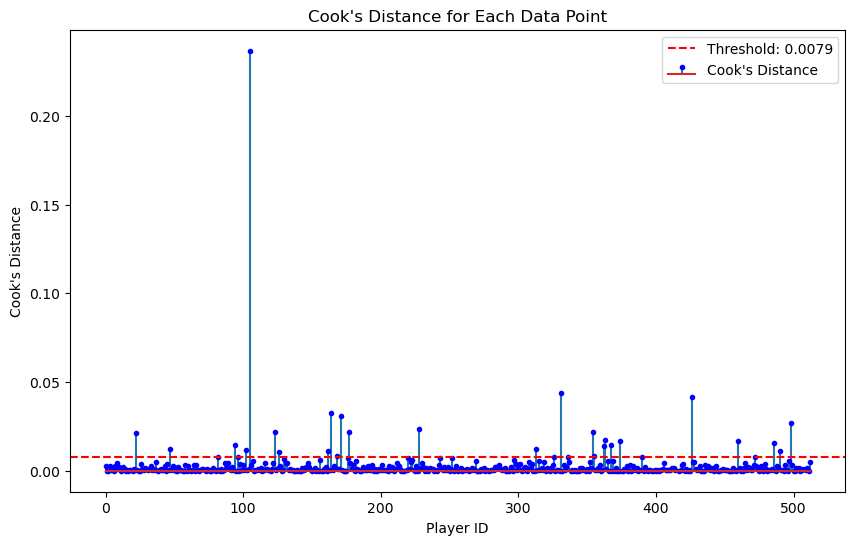

In [64]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_with_intercept)

results = pd.DataFrame({
    'Player': merged_clutch_goals.loc[y.index,'Player'],
    'Actual': y_log,
    'Predicted': ols_model.fittedvalues,
    'Cook\'s Distance': cooks_d
})

outliers_df = results.loc[results["Cook's Distance"] > threshold]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

### Final Scatter Plot from Training

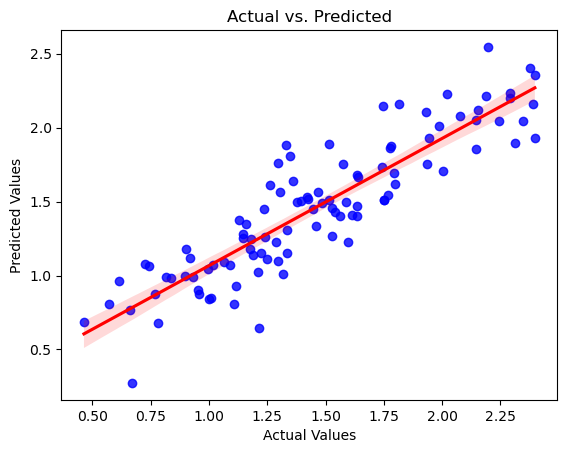

In [66]:
sns.regplot(data=merged_clutch_goals, x=test_y, y=y_pred, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Making Predicitons on Current Season Data

We save "ridge_cv_log" for reproductible results. We can then use it to make predictions on the current statistics of players (from 2024-2025 season to the current 2025-2026 season).

In [68]:
joblib.dump(ridge_cv_log, 'ridge_cv_model.pkl')
ridge_cv_log_loaded = joblib.load('ridge_cv_model.pkl')

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(epsilon, 'epsilon.pkl')

['epsilon.pkl']

In [69]:
all_seasons = []

for season in range(2024, 2026):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = pd.DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'goals': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'timeOnIcePerGame': 'mean',
            'teamAbbrevs': 'last'
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2024-2025
Successfully fetched data for season 2025-2026
      playerId  skaterFullName positionCode  gamesPlayed  goals  assists  \
0      8470600      Ryan Suter            D           82      2       13   
1      8470613     Brent Burns            D          119     11       37   
2      8470621     Corey Perry            R          112     26       20   
3      8471214   Alex Ovechkin            L          103     59       47   
4      8471215   Evgeni Malkin            C           94     24       55   
...        ...             ...          ...          ...    ...      ...   
1004   8485483  Karsen Dorwart            L            5      0        0   
1005   8485493   David Tomasek            R           22      3        2   
1006   8485511    Quinn Hutson            R            5      1        0   
1007   8485512       Tim Washe            C            2      0        0   
1008   8485702    Max Shabanov            R           25      3       

In [70]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 40)]
nhl_api_df = nhl_api_df.reset_index(drop = True)

rename_columns = {
    'otGoals': 'ot_goals',
    'skaterFullName': 'Player',
    'timeOnIcePerGame': 'time_on_ice_per_game'
}

nhl_api_df.rename(columns = rename_columns,  inplace = True)

In [71]:
start_season = "20242025"
end_season = "20252026"
goals_up_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
on_ice_url = f"https://www.naturalstattrick.com/playerteams.php?fromseason={start_season}&thruseason={end_season}&stype=2&sit=5v5&score=all&stdoi=oi&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [72]:
urls = {
    "goals_up_one": (goals_up_one_url, 'goals_up_by_one'),
    "goals_down_one": (goals_down_one_url, 'goals_down_by_one'),
    "tied": (tied_url, 'goals_when_tied'),
    "total": (total_url, 'total_goals'),
    "on_ice": (on_ice_url, '')
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]
on_ice_df = dataframes["on_ice"]
on_ice_df.columns = on_ice_df.columns.str.replace('\xa0', ' ')

In [73]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rebounds Created', 'iCF']]
on_ice_df = on_ice_df[['Player', 'Off. Zone Starts', 'On The Fly Starts']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df, on_ice_df]

merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 40]

rename_columns = {
    'Shots': 'shots',
    'Rebounds Created': 'rebounds_created',
    'Off. Zone Starts': 'off_zone_starts',
    'On The Fly Starts': 'on_the_fly_starts'
}
merged_natural_stat.rename(columns = rename_columns, inplace=True)

In [74]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson", "Alexander Nylander", "Jacob Lucchini", "Zack Bolduc", "Frederic Gaudreau"] 
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson", "Alex Nylander", "Jake Lucchini", "Zachary Bolduc", "Freddy Gaudreau" ]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [75]:
merged_clutch_goals_prediction = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')
merged_clutch_goals_prediction.drop(columns = 'GP', axis = 1, inplace = True)
merged_clutch_goals_prediction = merged_clutch_goals_prediction.dropna()

In [76]:
columns = ['ot_goals', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'iCF', 'rebounds_created', 'off_zone_starts', 'on_the_fly_starts']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals_prediction[per_game_string] = merged_clutch_goals_prediction[column] / merged_clutch_goals_prediction['gamesPlayed']

In [77]:
merged_clutch_goals_prediction['clutch_score'] = (
    0.45 * merged_clutch_goals_prediction['goals_down_by_one_per_game'] + 
    0.35 * merged_clutch_goals_prediction['goals_when_tied_per_game'] + 
    0.2 * merged_clutch_goals_prediction['ot_goals_per_game']
)

In [78]:
merged_clutch_goals_prediction['clutch_score'] *= 100
merged_clutch_goals_prediction['clutch_score_rank']  = merged_clutch_goals_prediction['clutch_score'].rank(ascending = False, method = 'min')
merged_clutch_goals_prediction['clutch_score'] = merged_clutch_goals_prediction['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals_prediction[['Player','clutch_score', 'clutch_score_rank']].head(20)

,Player,clutch_score,clutch_score_rank
149,Leon Draisaitl,15.18,1.0
212,Kirill Kaprizov,11.81,2.0
226,Alex DeBrincat,11.74,3.0
391,Dylan Guenther,11.70,4.0
253,Morgan Geekie,11.34,5.0
324,Cole Caufield,11.18,6.0
240,Tage Thompson,10.88,7.0
27,John Tavares,10.80,8.0
136,Bo Horvat,10.79,9.0
289,Brady Tkachuk,10.56,10.0


In [79]:
x_var = ['iSCF_per_game', 'assists_per_game', 'rebounds_created_per_game', 'time_on_ice_per_game', 'off_zone_starts_per_game']
X_adjusted = merged_clutch_goals_prediction[x_var]
y_var = 'clutch_score'
y = merged_clutch_goals_prediction[y_var]

scaler = joblib.load('scaler.pkl')
epsilon = joblib.load('epsilon.pkl')

X_scaled = scaler.transform(X_adjusted) 
X_scaled = np.nan_to_num(X_scaled, nan=0)

X_shifted = X_scaled + epsilon
X_log = np.log(X_shifted)

y_log = np.log(y + 1)
y_pred = ridge_cv_log_loaded.predict(X_log)

### Evaluating the Model after Testing
The R² indicates the model explains approximately 65% of variance in clutch performance, which is strong given the inherent randomness in clutch situations.

In [81]:
r2 = r2_score(y_log, y_pred)
rmse = np.sqrt(mean_squared_error(y_log, y_pred))
mae = mean_absolute_error(y_log, y_pred)

print(f"Test Set Performance:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


Test Set Performance:
R²: 0.6486
RMSE: 0.3280
MAE: 0.2423


In [82]:
y_pred = ridge_cv_log_loaded.predict(X_log)
merged_clutch_goals_prediction['predicted_clutch_score'] = y_pred 

merged_clutch_goals_prediction['log'] = np.log(merged_clutch_goals_prediction['clutch_score'] + 1) 
merged_clutch_goals_prediction['log_adjusted'] = np.log(merged_clutch_goals_prediction['clutch_score'] + 1) * 10
merged_clutch_goals_prediction['log_adjusted'] = merged_clutch_goals_prediction['log_adjusted'].apply(lambda x: round(x, 2))
merged_clutch_goals_prediction['predicted_clutch_score_adjusted'] = y_pred * 10
merged_clutch_goals_prediction = merged_clutch_goals_prediction.sort_values(by='predicted_clutch_score_adjusted', ascending = False)
merged_clutch_goals_prediction['predicted_clutch_score_adjusted'] = merged_clutch_goals_prediction['predicted_clutch_score_adjusted'].apply(lambda x: round(x, 2))

### Prediction Intervals
95% prediction intervals were generated for each player. If actual clutch scores fall outside the intervals, this indicates that clutch performance is significantly different from expectations. The intervals are generated using a bootstrap procedure with resampled residual noise, which ensures that the intervals reflect randomness in clutch performance.

In [84]:
n_boot = 1000
alpha = ridge_cv_log_loaded.alpha_

boot_preds = np.zeros((n_boot, len(X_log)))  

for i in range(n_boot):
    idx = np.random.choice(len(X_log), size=len(X_log), replace=True)

    X_res = X_log[idx]
    y_res = y_log.iloc[idx]

    ridge = Ridge(alpha=alpha)
    ridge.fit(X_res, y_res)

    preds = ridge.predict(X_log)

    residuals = y_log - ridge_cv_log_loaded.predict(X_log)
    noise = np.random.choice(residuals, size=len(X_log), replace=True)

    boot_preds[i] = preds + noise

lower_log = np.percentile(boot_preds, 2.5, axis=0)
upper_log = np.percentile(boot_preds, 97.5, axis=0)

merged_clutch_goals_prediction['lower_bound_log'] = (lower_log * 10).round(2)
merged_clutch_goals_prediction['upper_bound_log'] = (upper_log * 10).round(2)

merged_clutch_goals_prediction['Significantly_Clutch'] = np.where(
    (merged_clutch_goals_prediction['log_adjusted'] >= merged_clutch_goals_prediction['lower_bound_log']) &
    (merged_clutch_goals_prediction['log_adjusted'] <= merged_clutch_goals_prediction['upper_bound_log']),
    'Inside Range',
    'Outside Range'
)

### Shap Values

SHAP values were calculated to explain which features most influenced each player's prediction. This is useful for the dashboard since users can understand how clutch scores are predicted. 

In [86]:
explainer = shap.LinearExplainer(ridge_cv_log_loaded, X_log)
shap_values = explainer(X_log)

shap_df = pd.DataFrame(
    shap_values.values,     
    columns=X_adjusted.columns,
    index=X_adjusted.index
)

for col in shap_df.columns:
    merged_clutch_goals_prediction[f'shap_{col}'] = shap_df[col]

### Cook's Distance Observations

The model shows the same patterns as before - it undervalues and overvalues some players. Clutch scores of low performing players are also amplified by the log transformation. These players are excluded in the final dashboard by only including players with 20+ goals.

There are 32 influential points.
Outliers based on Cook's Distance:
                 Player    Actual  Predicted  Cook's Distance
0      Nathan MacKinnon  2.354228   2.566055         0.011729
77       William Eklund  1.835776   1.979267         0.031944
103       Conor Garland  1.821318   1.909293         0.020966
109       Ryan O'Reilly  2.033398   1.902727         0.010720
128   Pierre-Luc Dubois  1.593309   1.827881         0.018107
144      Warren Foegele  1.938742   1.774610         0.013290
184    William Karlsson  1.453953   1.628294         0.012205
199    Jordan Martinook  1.081805   1.579310         0.012269
209     Kiefer Sherwood  2.127041   1.538187         0.033029
216   Nino Niederreiter  1.479329   1.522605         0.010313
220    Christian Dvorak  1.208960   1.509226         0.012142
251         Matt Savoie  0.593327   1.415087         0.019618
302           Noah Laba  1.286474   1.265439         0.012616
332         Colton Dach  1.275363   1.154192         0.009883
35

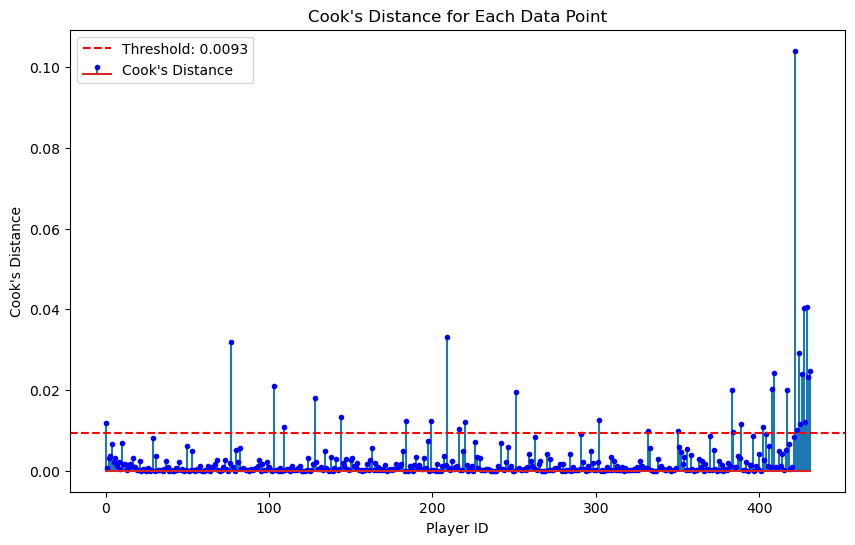

In [88]:
X_with_intercept = sm.add_constant(X_log)

ols_model = sm.OLS(y_log, X_with_intercept).fit()

influence = ols_model.get_influence()
cooks_d, _ = influence.cooks_distance

threshold = 4 / len(X_adjusted)

merged_clutch_goals_prediction = merged_clutch_goals_prediction.reset_index(drop=True)

results = pd.DataFrame({
    'Player': merged_clutch_goals_prediction['Player'].values,
    'Actual': merged_clutch_goals_prediction['log'].values,
    'Predicted': merged_clutch_goals_prediction['predicted_clutch_score'].values,
    "Cook's Distance": cooks_d
})

outliers_df = results.loc[results["Cook's Distance"] > threshold]

print("There are", outliers_df.shape[0], "influential points.")
print("Outliers based on Cook's Distance:")
print(outliers_df)

plt.figure(figsize=(10, 6))
plt.stem(results.index, cooks_d, markerfmt='b.', label="Cook's Distance")
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Player ID")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Each Data Point")
plt.legend()
plt.show()

### Final Scatter Plot after Testing
The Actual vs. Predicted shows a well-fitted model for clutch performance. There is a strong linear releationship and homoscedasticity. Some points may deviate from the line of best fit, but this is to be expected due to players naturally overperforming/underpeforming their clutch scores. 

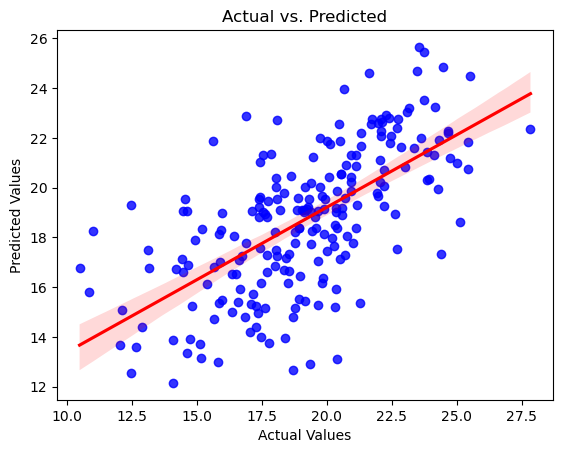

In [90]:
merged_clutch_goals_prediction = merged_clutch_goals_prediction.loc[merged_clutch_goals_prediction['total_goals'] >= 20]
sns.regplot(data=merged_clutch_goals_prediction, x=merged_clutch_goals_prediction['log_adjusted'], y=merged_clutch_goals_prediction['predicted_clutch_score_adjusted'], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

### Conclusion
Through this project, I hope that NHL fans can identify forwards who perform well in close game situations and use the regression model to determine if they are underperforming/overperforming expectations. The SHAP analysis should make the model less of a "black box" and enable users to gain more insight into playing styles that influence the predictions. For those more statistically inclined, the prediction intervals can show players who are truly "clutch". 

While there were still some influential points in the final model, these points may be useful in determining overvalued and undervalued players. One potential limitation in the cltuch score is that it includes goals from all periods. It would be useful to have only third period goals given these are the most clutch goals, but I was not able to filter by period on Natural Stat Trick. 